In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from cifar10 import load_cifar10 # 输入数据，主要用了tf.data.FixedLengthRecordDataset

In [2]:
help(load_cifar10)
print(tf.__version__)

Help on function load_cifar10 in module cifar10:

load_cifar10(data_dir, batch_size, test=False, shuffle=True, seed=None)

1.7.0


In [3]:
data_path = r"E:\Code\jupyterpy\DigitalVideo\datasets\cifar-10-batches-bin"
BATCH_SIZE_TRAIN = 100
TRAIN_SIZE = 50000
TEST_SIZE = 10000

##### 数据：Cifar10 二进制版本
<img src="data.jpg" width="300" height="100">

# Model

In [4]:
def model_(xs):
    # (n, 32, 32, 3)
    conv1 = tf.layers.conv2d(xs, filters=32, kernel_size=5, strides=1, padding='SAME', activation=tf.nn.relu, 
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), name="conv1", reuse=tf.AUTO_REUSE)
    tf.summary.histogram('conv1', conv1)
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2, name='max_pool1')
    # (n, 16, 16, 32)
    conv2 = tf.layers.conv2d(pool1, filters=32, kernel_size=5, strides=1, padding='SAME', activation=tf.nn.relu, 
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), name="conv2", reuse=tf.AUTO_REUSE)
    tf.summary.histogram('conv2', conv1)
    pool2 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2, name='max_pool2')
    # (n, 8, 8, 32)
    fc1 = tf.reshape(pool2, [-1, 8 * 8 * 32])
    output = tf.layers.dense(fc1, 10, name="fc1", reuse=tf.AUTO_REUSE)
    return output

In [5]:
def loss_acc(ys, output, train=True):
    with tf.name_scope('loss'):
        loss = tf.losses.softmax_cross_entropy(onehot_labels=ys, logits=output)
        tf.summary.scalar('loss', loss)
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output, 1), tf.argmax(ys, 1)), tf.float32))
        tf.summary.scalar('accuracy', accuracy)
    return loss, accuracy

# Train

In [6]:
def plt_loss_acc(epoch_loss_list, epoch_acc_list, epoch_loss_val_list, epoch_acc_val_list):
    plt.figure(figsize=(14, 5))
    plt.subplot(121)
    plt.plot(epoch_loss_list, label='Train loss')
    plt.plot(epoch_loss_val_list, label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc=0)

    plt.subplot(122)
    plt.plot(epoch_acc_list, label='Train acc')
    plt.plot(epoch_acc_val_list, label='Val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend(loc=0)
    plt.show()

In [7]:
def train(dataset, dataset_val, TRAIN_SIZE, VAL_SIZE, BATCH_SIZE_TRAIN):
    '''
    data
    '''
    with tf.name_scope('data'):
        iter = tf.data.Iterator.from_structure(dataset.output_types, 
                                               dataset.output_shapes)
        train_init_op = iter.make_initializer(dataset)
        val_init_op = iter.make_initializer(dataset_val)

        xs, ys = iter.get_next()
        ys = tf.reshape(ys, (-1, 10))
    '''
    model
    '''
    output = model_(xs)
    loss, accuracy = loss_acc(ys, output)
    train_op = tf.train.AdamOptimizer(1e-5, name='Adam').minimize(loss)
    #accuracy = tf.metrics.accuracy(labels=tf.argmax(ys, axis=1), predictions=tf.argmax(output, axis=1))
    '''
    train process
    '''
    
    N_EPOCH = 200
    epoch_loss_list = []
    epoch_acc_list = []
    epoch_loss_val_list = []
    epoch_acc_val_list = []
    N_BATCH, N_BATCH_VAL = TRAIN_SIZE // BATCH_SIZE_TRAIN, VAL_SIZE // BATCH_SIZE_TRAIN
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('./graphs/train', tf.get_default_graph())
        val_writer = tf.summary.FileWriter('./graphs/val')
        saver = tf.train.Saver()

        if not os.path.exists('model'):
            os.mkdir('model')
            
        summary_op = tf.summary.merge_all()
        #val_summary_op = tf.summary.merge_all()
        for epoch in range(N_EPOCH):
            i = 0
            epoch_acc = 0.0 # 用于plt画图
            epoch_loss = 0.0
            epoch_acc_val = 0.0
            epoch_loss_val = 0.0
            '''
            Train
            '''
            sess.run(train_init_op) # 训练集数据
            for i in range(N_BATCH):
                _, summary, _loss, acc = sess.run([train_op, summary_op, loss, accuracy])
                epoch_acc += acc
                epoch_loss += _loss
            if (epoch + 1) % 20 == 0:
                saver.save(sess, 'model/cifar10_cnn.ckpt', global_step=epoch + 1)
            #writer.add_summary(summary=summary, global_step=epoch)
            epoch_acc /= N_BATCH
            epoch_loss /= N_BATCH
            epoch_acc_list.append(epoch_acc)
            epoch_loss_list.append(epoch_loss)
            summary_ = tf.Summary()
            summary_.ParseFromString(summary)
            summary_.value.add(tag='accuracy', simple_value=epoch_acc)
            summary_.value.add(tag='loss', simple_value=epoch_loss)
            writer.add_summary(summary=summary_, global_step=epoch)
            
            '''
            Val
            转用验证集数据，先把10000测试集张图片shuffle(seed=42)，把偶数batch的数据作为验证数据
            '''
            sess.run(val_init_op)
            for i in range(N_BATCH_VAL):
                summary_val, loss_val, acc_val = sess.run([summary_op, loss, accuracy])
                if i % 2 == 0:# 偶数用于验证
                    epoch_acc_val += acc_val
                    epoch_loss_val += loss_val
            epoch_acc_val /= N_BATCH_VAL / 2
            epoch_loss_val /= N_BATCH_VAL / 2
            epoch_acc_val_list.append(epoch_acc_val)
            epoch_loss_val_list.append(epoch_loss_val)
            summary_ = tf.Summary()
            summary_.ParseFromString(summary_val)
            summary_.value.add(tag='accuracy', simple_value=epoch_acc_val)
            summary_.value.add(tag='loss', simple_value=epoch_loss_val)
            val_writer.add_summary(summary=summary_, global_step=epoch)
            
            print("epoch {0} / {1:}\t:Train loss {2:.5f}\t Train acc {3:.5f}: \
                  Val loss {4:.5f}\t Val acc {5:.5f}".format(epoch + 1, N_EPOCH, epoch_loss, epoch_acc, epoch_loss_val, epoch_acc_val))
        plt_loss_acc(epoch_loss_list, epoch_acc_list, epoch_loss_val_list, epoch_acc_val_list)
    writer.close()
    val_writer.close()

epoch 1 / 200	:Train loss 2.30287	 Train acc 0.17074:                   Val loss 2.14543	 Val acc 0.21880
epoch 2 / 200	:Train loss 2.07422	 Train acc 0.25596:                   Val loss 2.00364	 Val acc 0.27900
epoch 3 / 200	:Train loss 1.95998	 Train acc 0.30116:                   Val loss 1.91707	 Val acc 0.31260
epoch 4 / 200	:Train loss 1.87468	 Train acc 0.33188:                   Val loss 1.84852	 Val acc 0.33560
epoch 5 / 200	:Train loss 1.80627	 Train acc 0.35612:                   Val loss 1.79149	 Val acc 0.35460
epoch 6 / 200	:Train loss 1.74961	 Train acc 0.37412:                   Val loss 1.74930	 Val acc 0.37060
epoch 7 / 200	:Train loss 1.70275	 Train acc 0.39126:                   Val loss 1.71172	 Val acc 0.38260
epoch 8 / 200	:Train loss 1.66332	 Train acc 0.40610:                   Val loss 1.67743	 Val acc 0.39460
epoch 9 / 200	:Train loss 1.62852	 Train acc 0.41874:                   Val loss 1.65275	 Val acc 0.40360
epoch 10 / 200	:Train loss 1.59852	 Train acc 

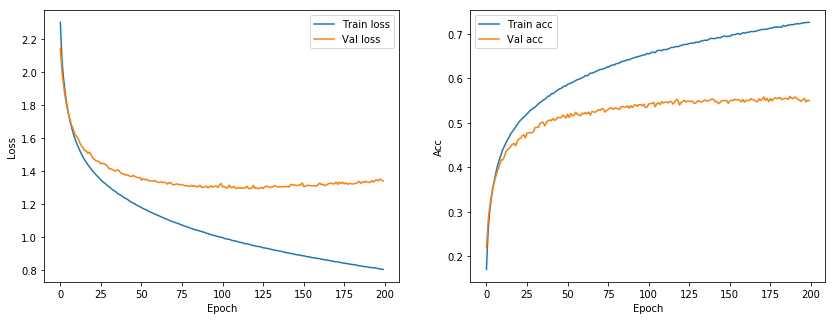

In [8]:
dataset = load_cifar10(data_path, BATCH_SIZE_TRAIN, shuffle=True)#训练集数据
dataset_val = load_cifar10(data_path, BATCH_SIZE_TRAIN, test=True, shuffle=True, seed=42)#验证集数据
train(dataset, dataset_val,TRAIN_SIZE, TEST_SIZE, BATCH_SIZE_TRAIN)

# Test

In [9]:
def test(dataset, TEST_SIZE, batch_size):
    iter = dataset.make_one_shot_iterator()
    xs, ys = iter.get_next()
    ys = tf.reshape(ys, (BATCH_SIZE_TRAIN, 10))
    
    output = model_(xs)
    loss, accuracy = loss_acc(ys, output)
    
    N_BATCH_TEST =  TEST_SIZE // batch_size
    print("Numbers of testing batch size: ", N_BATCH_TEST)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('model/checkpoint'))
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        for epoch in range(1):
            e_loss = 0.0
            e_acc = 0.0
            for i in range(N_BATCH_TEST):
                _loss, acc = sess.run([loss, accuracy])
                if i % 2 == 1:# 奇数用于测试
                    e_loss += _loss
                    e_acc += acc
            epoch_loss = 2 * e_loss / N_BATCH_TEST
            epoch_acc = 2 * e_acc / N_BATCH_TEST
            print("epoch {0} / {1:}\t Test acc {2:.5f}".format(epoch + 1, 1, epoch_acc))

In [10]:
dataset_test = load_cifar10(data_path, BATCH_SIZE_TRAIN, test=True, shuffle=True, seed=42)
test(dataset_test, TEST_SIZE, BATCH_SIZE_TRAIN)

Numbers of testing batch size:  100
INFO:tensorflow:Restoring parameters from model\cifar10_cnn.ckpt-200
epoch 1 / 1	 Test acc 0.55660
